# Auto Labelling (Demo)
In this Jupyter notebook, we aim to illustrate the poential of the \[semi\] auto labelling tool. In our example we will use it to label movie categories (original example by author).

In [1]:
import pandas as pd
import numpy as np

from src.toolkit.plot import barplot
from src.toolkit.autolabel import Preprocessor, AutoLabeller, check_labels
from src.toolkit.autolabel import recommend_words, Evaluator

from sklearn.naive_bayes import MultinomialNB

## Input Data
Our input data is a csv file containing text data in the first column. A subset of the [Full MovieLens Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/home) is used for demonstration purposes.

In [2]:
texts_path = "data/movies/movies.csv"
stopwords_path = "data/stopwords.csv"

movies = pd.read_csv(texts_path)
movies.head()

,overview,Action,Romance,Science Fiction,Thriller,War,Western
0,A family wedding reignites the ancient feud be...,0,1,0,0,0,0
1,"Cheated on, mistreated and stepped on, the wom...",0,1,0,0,0,0
2,"Obsessive master thief, Neil McCauley leads a ...",1,0,0,1,0,0
3,An ugly duckling having undergone a remarkable...,0,1,0,0,0,0
4,"A mischievous young boy, Tom Sawyer, witnesses...",1,0,0,0,0,0


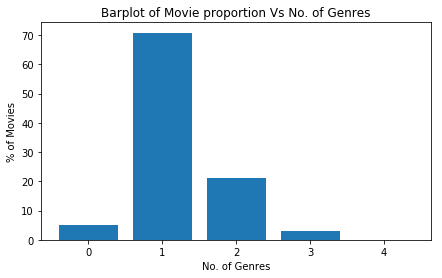

It seems that most movies tend to only have 1 genre. This makes sense!


In [3]:
moviesGenre = movies.iloc[:, 1:]
numGenres = list(range(5))
labelCount = [round((moviesGenre.sum(axis=1)==i).mean(),3)*100 for i in range(5)]

barplot(numGenres, 
        labelCount, 
        figsize=(7,4), 
        title='Barplot of Movie proportion Vs No. of Genres',
        x_label='No. of Genres',
        y_label='% of Movies')

print("It seems that most movies tend to only have 1 genre. This makes sense!")

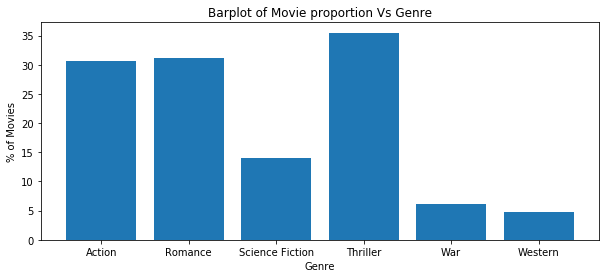

We appear to have a skewed dataset. There isn't as much science fiction, war and western films.
Combined with the relatively small dataset used, this can make it difficult to label our dataset!


In [4]:
genreTitle = moviesGenre.columns
movieCount = (round(moviesGenre.mean(axis=0),3)*100).tolist()

barplot(genreTitle, 
        movieCount, 
        figsize=(10, 4), 
        title='Barplot of Movie proportion Vs Genre',
        x_label='Genre',
        y_label='% of Movies')

print("We appear to have a skewed dataset. There isn't as much science fiction, war and western films.\n\
Combined with the relatively small dataset used, this can make it difficult to label our dataset!")

## Data Preprocessing
For text data, it is important to perform preprocessing. In our case the following will be performed.
* Vectorise data. Convert text data into a numerical format.
* Prepare text. Some operations are removng special characters, digits and stopwords etc. 
* Join bigrams that appear frequently into one word.

In [5]:
corpus = movies['overview']

preprocessor = Preprocessor()

# Text Preprocessing
preprocessed_corpus = preprocessor.corpus_preprocess(corpus=corpus, stopwords_path=stopwords_path)

# Replace bigrams
movies['overview'] = preprocessor.corpus_replace_bigrams(corpus=preprocessed_corpus, min_df=50, max_df=500)

## Generate Recommended Labels
Here we will build the label dictionary. Running the following code will generate recommended words and allows us to pick relevant words from the dictionary. The recommended word dictionary may look daunting, but it is simple to use!

Explaining the matrix: Each row represents a 'topic' that the model has identified. Therefore, there may be \[multiple\] rows that represent themes like 'romance', 'thriller' etc!

Go ahead and run the following snippet of code to continue!

In [6]:
n_words = 20  # CHANGE THE NUMBER OF WORDS RECOMMENDED (IF YOU WANT TO)

# Returns a matrix of recommended words
topic_model, dtm, best_n = recommend_words(corpus) 
topic_model.show_topics(dtm=dtm, best_n=best_n, n_words=n_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,paris,date,wedding,apartment,married,best_friend,party,romantic,perfect,sex,friendship,london,successful,baby,ask,share,year_old,feeling,divorce,feel
1,terrorist,hostage,bomb,president,nuclear,international,london,prevent,special,security,unit,cia,united,release,commando,cell,elite,computer,hijack,major
2,band,gold,outlaw,western,sheriff,stranger,west,mexican,desert,bandit,ranch,gun,texas,mexico,civil_war,wild,small_town,cattle,border,cowboy
3,ii,japanese,camp,nazi,prisoner,jewish,france,wwii,resistance,japan,allied,pilot,true_story,concentration,line,unit,pow,germany,troop,invasion
4,king,princess,prince,warrior,defeat,kingdom,quest,throne,queen,hero,court,rule,ancient,general,god,monster,classic,royal,epic,legendary
5,ship,space,captain,pirate,passenger,board,crash,sea,station,creature,submarine,pilot,survivor,astronaut,cargo,aboard,moon,nuclear,plane,spaceship
6,truth,memory,haunt,accident,experiment,mystery,wake,hospital,ghost,reality,witness,spirit,commit,trap,patient,five,person,nightmare,mind,suicide
7,high_school,teacher,kid,class,teenage,crush,senior,teenager,teen,friendship,popular,summer,classmate,best_friend,separate,teach,graduation,develop,graduate,gym
8,indian,cavalry,tribe,india,reservation,chief,fort,white,territory,peace,raise,west,wagon,defend,bandit,pakistani,president,america,term,settler
9,comedy,book,drama,role,direct,feature,writer,documentary,actor,thriller,novel,classic,famous,comic,musical,film_direct,release,music,produce,artist


## Filter labels dictionary
First lets look at the recommended words. It seems like row 0 and row 7 are themes related to 'romance', lets extract the words 'date', 'wedding', 'married' and romantic.

Now, we need to filter the labels dictionary. The romance data can be taken from row 0 and row 7!

You can also identify that some rows more closely relate to the other themes.

In [7]:
labels_path = "data/movies/labels.csv"
labels = pd.read_csv(labels_path)
labels = check_labels(movies[['overview']], labels)
labels.head(10)

,Action,Romance,Science Fiction,Thriller,War,Western
0,terrorist,college,space,serial_killer,ii,indian
1,assassin,high_school,astronaut,murderer,nazi,cavalry
2,master,wedding,spaceship,solve,camp,reservation
3,gangster,date,galaxy,terrorize,troop,tribe
4,target,friendship,moon,fbi_agent,allied,chief
5,ruthless,married,humanity,target,general,fort
6,martial_art,summer,unknown,justice,wwii,west
7,cia,love_story,survivor,thriller,invasion,wagon
8,fighter,teenage,universe,witness,prisoner,gold
9,mob,romantic,robot,police_officer,vietnam,western


## Enrich Labels Dictionary
In this step, we will use the initial labels dictionary we filtered as a seed to generate more recommended labels.

In [8]:
autoLabeller = AutoLabeller(labels, corpus, movies)
enriched_labels = autoLabeller.train(n_words=20)

enriched_labels.head(10)

,Action,Romance,Science Fiction,Thriller,War,Western
0,spy,senior,monster,spy,lt,indian
1,mafia,college,spacecraft,mafia,allied,posse
2,fighter,attend,lab,international,jewish,wild
3,international,sex,giant,supernatural,raid,chief
4,martial_art,romantic,unknown,pursuit,general,horse
5,china,divorce,mutate,haunt,commander,confederate
6,master,musical,infect,hostage,command,sheriff
7,lung,married,universe,true_story,history,territory
8,fu,dance,moon,investigation,vietnam,cavalry
9,warrior,two_young,creature,accident,ww,cowboy


## Model Application
The model utilises enriched labels, trains and applies multinomial naive bayes on input dataset. 

**Note that it can take awhile to run**.

In [9]:
mnb = MultinomialNB()
ypred = autoLabeller.apply(mnb, 'overview')

/Users/jinjun/Desktop/aisg/makerspace/bricks/bricks-auto-labeller/src/helper/label.py:129: RuntimeWarning: invalid value encountered in true_divide
  doc_npmi_embed = np.array(np.divide(doc_npmi_embed,self.tf_dtm.sum(axis=1).reshape(-1,1)))


## Output Data
Now lets look at the labels that the model has generated.

In [10]:
labelled_path = "data/movies/movies_labelled.csv"

output = movies[["overview"]].join(ypred)
output.to_csv(labelled_path)
output.head(5)

,overview,Action,Romance,Science Fiction,Thriller,War,Western
0,family wedding reignite ancient feud nextdoor ...,0.0,1.0,0.0,0.0,0.0,0.0
1,cheat mistreat step woman hold breath wait elu...,0.0,0.0,0.0,0.0,0.0,0.0
2,obsessive master thief lead topnotch crew vari...,0.0,0.0,0.0,1.0,0.0,0.0
3,duckling undergone remarkable change harbor fe...,0.0,1.0,0.0,0.0,0.0,0.0
4,mischievous young_boy witness murder becomes f...,1.0,1.0,0.0,0.0,0.0,0.0


## Evaluate Model
As this dataset already has labels, we may evaluate the model using the precision, recall and f1 score. Seems like our model performs well on romance. It appears that the model may need to be improved for the remainder of the data. This is expected as there are insufficient training data and labels.

In [11]:
evaluator = Evaluator()
evaluator.evaluate_predictions(movies, ypred,  labels, split=0.2, random_state=42)

,Action,Romance,Science Fiction,Thriller,War,Western
Precision,0.3929,0.5554,0.4673,0.6647,0.3499,0.3333
Recall,0.5711,0.3541,0.6072,0.2997,0.6494,0.8019
F1-score,0.4655,0.4325,0.5281,0.4131,0.4548,0.4709
